# Plotting Correlations between Cloud Variables vs. Radiation

## Intro

**Model Setup**

ICON is run for the same case with different radiation timesteps:

- namelist flag `dt_rad = [900, 60, 120, 240, 480, 1800]`

- A ICON-LEM setup using ECRAD radiation coupling is used. Grid spacing is around 600m. 

- The condensate velocity is around 15 m/s - so quite a bit of wind during this selected case. It take around 40 secounds for a cloud to leave one grid box and enter the neighboring one. Depending on cloud size, advective motion leads to a complete mismatch between clouds at t to clouds t + (a few minutes).

- A reference run is integrated forward from 0z to 9z for each case using `dt_rad = 900` and sensitivity runs are started thereafter from 9z to 10z.

- This is a small ICON setup (5e5 grid cells), just to illustrate the problem in the radiation-cloud coupling.


**Concept**

We like to explore here how infrequent radiation calculations in ICON start to diverge from the underlying cloud fields.

- Radiatio fields are stored each minutes (much higher output frequency than radiation calling frequency for most experiments) 

- We use standard output variables and no additional model-internal diagnostic. 

- We approximate the reflectivity of the liquid cloud fields by the simplified formulation of Cahalan et al. (1994). This provides a non-linear transformation of liquid water patrh (LWP) into reflectivity. 

## Analysis 

### Import Libraries 

In [1]:
import glob 

import numpy as np
import xarray as xr

import pylab as plt

import seaborn as sns
sns.set_context ('talk')

### Input Data

#### ICON Grid 

In [2]:
grid = xr.open_dataset('/work/bb1174/data/icon-lem/grids-extpar/xsdom1/xsdom1.nc')

grid = grid.isel( cell = slice(20000, None)) # use inner domain, hard coded -> bad!

# read center lon/lat in radiant
clon_rad = grid['clon']                # center longitude  / rad
clat_rad = grid['clat']                # center latitutde  / rad

# convert to degrees
clon = np.rad2deg( clon_rad )
clat = np.rad2deg( clat_rad )

#### ICON Experiment Data 

In [3]:
basedir = "/work/bb1174/user/fabian/models/icon/icon-builds-on-levante/build-v2.6.5-radweights_4testing/experiments/"

In [4]:
#plt.plot(d.time)

**Importer**

- the below importer maps all experiments to certain cases
- three cases have been conducted
    - "case1" : calm case, minor cloud changes due to advection and locale (Lagrangian changes) -> infrequent radiation computation work better here
    - "case2" : stormy spring weather, significant advective motion
    - "case3" : stormy autumn weather, also significant advective motion

In [5]:

explist = {'case1': ['exp011', 'exp013', 'exp014', 'exp015', 'exp016', 'exp017'],
           'case2': ['exp022', 'exp023', 'exp024', 'exp025', 'exp026', 'exp027'],
           'case3': ['exp032', 'exp033', 'exp034', 'exp035', 'exp036', 'exp037']}

i = 0
dset = {}
for case in ['case1', 'case2', 'case3']:
    dlist = []
    for expname in explist[case]:
        expdir = f'smarract_rad_scaling_{expname}'


        if case == 'case1':
            date = '20130502T12'
        elif case == 'case2':
            date = '20220521T09'
        elif case == 'case3':
            date = '20221002T09'

        print ( expname, date )

        cloudname = f'{basedir}/{expdir}/2d_cloud_DOM01_ML_{date}0000Z.nc'
        cloudset = xr.open_dataset( cloudname, chunks={'time':2} )

        radname = f'{basedir}/{expdir}/2d_rad_DOM01_ML_{date}0000Z.nc'
        radset = xr.open_dataset( radname, chunks={'time':2} )

        d = xr.merge( [cloudset, radset])
        
        if case == 'case2':
            d = d.isel( time = slice(11,None))

        d = d.expand_dims('expname')
        d['expname'] = [expname,]

        dlist += [d,]
    #bugfix for restarted runs
    #dlist[0] = dlist[0].isel(time = slice(None, -4))

    dset[case] = xr.concat(dlist, dim = 'expname').sel(ncells = slice(20000, None))

exp011 20130502T12
exp013 20130502T12
exp014 20130502T12
exp015 20130502T12
exp016 20130502T12
exp017 20130502T12
exp022 20220521T09
exp023 20220521T09
exp024 20220521T09
exp025 20220521T09
exp026 20220521T09
exp027 20220521T09
exp032 20221002T09
exp033 20221002T09
exp034 20221002T09
exp035 20221002T09
exp036 20221002T09
exp037 20221002T09


#### Calculate Additional Variables 

* **planetary albedo**: TOA solar radiation proxy variable (independent of incoming flux)

In [6]:
for case in dset:
    d = dset[case]
    F_up = np.abs( d['sob_t'] - d['sod_t'] )
    d['albedo'] = F_up / d['sod_t']



* **cloud reflectivity**: simple cloud proxy Ukind of comparable with planetary albedo (however assumes several severe simplications like constant effective droplet radius, etc.) 

In [7]:
# Cahalan et al. (1994)
for case in dset:
    d = dset[case]
    twp = ( d['clwvi'] + d['clivi'] )* 1e3  #  also included ice water path here
    
    reff_factor = 0.05  # adjusted such that brightness fits
    tau = reff_factor * twp

    gam = 0.1
    d['tau'] = tau
    d['R_c'] = gam * tau / ( 1 + gam *tau)


### Correlation Analysis

Next, we correlate the two proxies: 
1. planetary albedo as radiation proxy
2. cloud reflectivity as cloud proxy


#### Random Column Selection 

To keep the computational overhead low, only a few randomly selected columns are analyzed.

In [8]:
rindex = np.random.choice( d.ncells, size = 10000).data

* for all cases, but the last time stored 

In [9]:
# this setups up data vectors for the last time stored before
# the next radiation is called i.e. 9:59 for case2 and case3

dvec = {}
for case in dset.keys():
    dvec[case] = dset[case].isel(time = -1).isel(ncells = rindex)

In [10]:
# this does the correlation 
ccvec = {}
for case in dset.keys():
    cc = []
    for expname in dvec[case].expname.data:
        # print(expname)
        x = dvec[case]['R_c'].sel( expname = expname).load().data
        y = dvec[case]['albedo'].sel(expname = expname).load().data

        x = np.ma.masked_invalid( x )
        y = np.ma.masked_invalid( y )

        #plt.plot(x ,y , 'o' )

        cc += [np.ma.corrcoef(x,y)[0,1],]
        
    ccvec[case] = cc

* for case2, but the full time series

In [11]:
c2 = dset['case2'].isel( ncells = rindex )

In [12]:
ccvec2 = []

for expname in c2.expname.data:
    cc = []
    for t in c2.time:
        x = c2['R_c'].sel( time = t, expname = expname).load().data
        y = c2['albedo'].sel(time = t, expname = expname).load().data

        x = np.ma.masked_invalid( x )
        y = np.ma.masked_invalid( y )

        #plt.plot(x ,y , 'o' )

        cc += [np.ma.corrcoef(x,y)[0,1],]
    
    dtime = 60*24*(c2.time - c2.time.isel(time = 0))
    dcc = xr.DataArray( cc, dims = 'time', coords = {'time':dtime})
    ccvec2 += [dcc,]

### Plotting

#### Maps

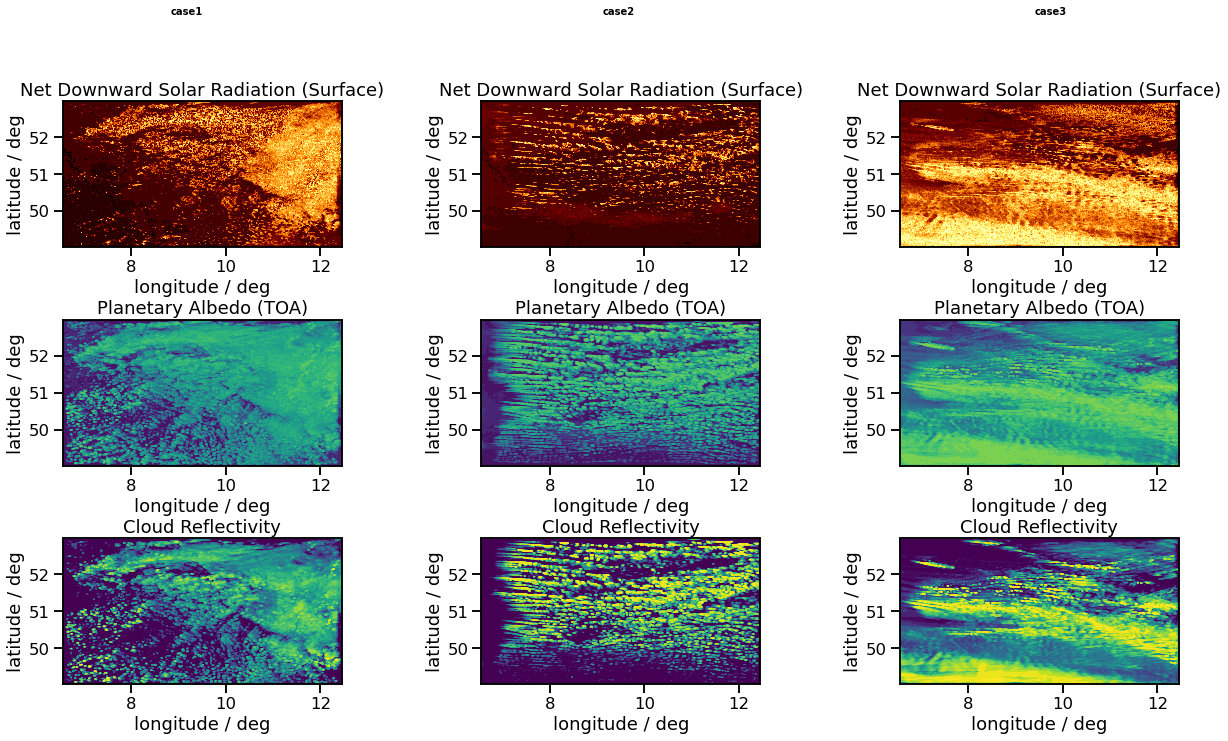

In [13]:
#reg = dict( lon = slice(7,8), lat = slice(50.5, 51))

fig, axs = plt.subplots(ncols = 3, nrows = 3, figsize = (20,12))
plt.subplots_adjust( wspace = 0.5, hspace = 0.5, top = 0.8)
for n, case in enumerate (dset.keys()):
    s = dset[case]['sob_s'].isel(time = -1, expname=1,)
    a = dset[case]['albedo'].isel(time = -1, expname=1,)
    r = dset[case]['R_c'].isel(time = -1, expname=1,)


    axs[0, n].tricontourf( clon, clat, s, levels = 20, cmap = plt.cm.afmhot_r )
    axs[0, n].set_title('Net Downward Solar Radiation (Surface)')
    
    axs[1, n].tricontourf( clon, clat, a, levels = 20, vmin = 0.1, vmax = 0.9)
    axs[1, n].set_title('Planetary Albedo (TOA)')
    
    axs[2, n].tricontourf( clon, clat, r, levels = 20, vmin = 0.1, vmax = 0.9)
    axs[2, n].set_title('Cloud Reflectivity')
    
    plt.figtext(0.3*n + 0.2, 0.9, case, fontweight = 'bold')
    
for a in axs.flatten():
    a.set_xlabel('longitude / deg')
    a.set_ylabel('latitude / deg')
    

#### Correlation Results 

In [14]:
dt_rad = np.array([15, 1, 2, 4, 8, 30])
t_since_rad = np.array([14, 0, 1, 3, 7, 29])

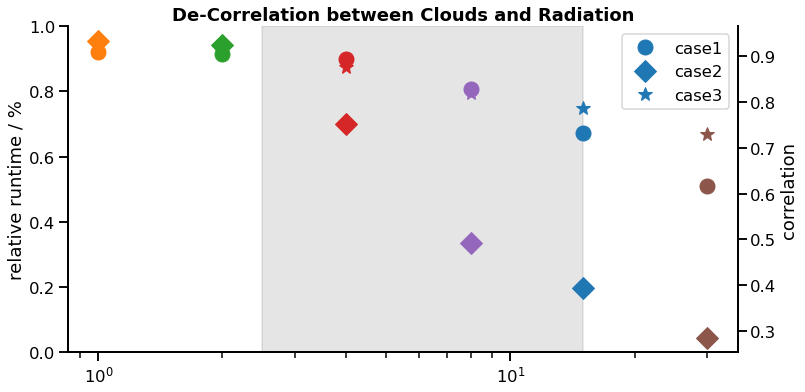

In [15]:

fig = plt.figure(figsize = (12, 6))
ax = plt.gca()
ax2 = ax.twinx()

#y = dset['case1']['asob_t'].isel(time=-10).sel(expname = explist_case1).load().data

cols = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5']
marks= ['o', 'D', '*']
coll = []
for k, case in enumerate( dset.keys() ):
    for i in range( len(dt_rad)):
    
        x = dt_rad[i]

        li, = ax2.plot( x, ccvec[case][i], lw = 0, marker = marks[k], ms = 15, color = cols[i] )

        if i == 0:
            coll += [li,]
            
plt.xlabel('radiation timestep / (min)')
ax.set_ylabel('relative runtime / %')
ax2.set_ylabel('correlation')

plt.axvspan( 2.5,15, alpha = 0.1, color = 'k')
plt.xscale('log')
plt.legend(labels = ['case1', 'case2', 'case3'], 
           handles = coll)

plt.title( 'De-Correlation between Clouds and Radiation', fontweight = 'bold', )
sns.despine(top = True, right = False)

Text(0.5, 1.0, 'Temporal Evolution\n of Cloud-Radiation-Correlations')

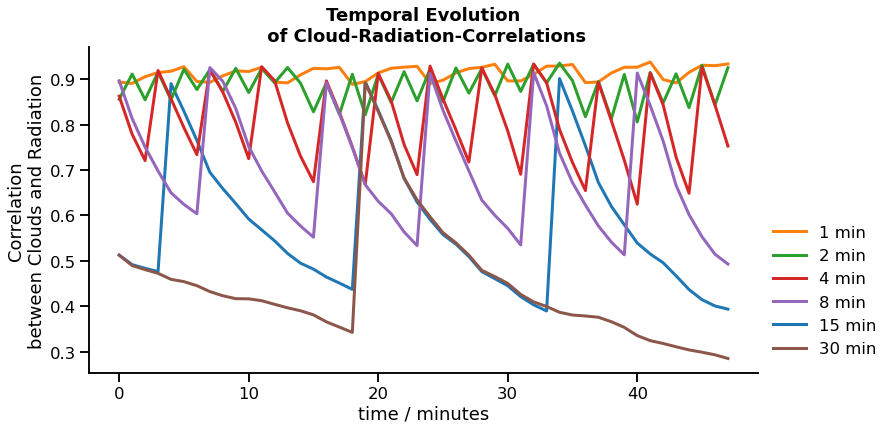

In [16]:

fig = plt.figure(figsize = (12, 6))
ax = plt.gca()

#y = dset['case1']['asob_t'].isel(time=-10).sel(expname = explist_case1).load().data

cols = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5']

coll = []
for n, expname in enumerate( c2.expname.data ):

    cc = ccvec2[n]
    li, = cc.plot(x = 'time', color = cols[n], lw = 3)
    
    coll +=[li,]
sns.despine()
plt.ylabel('Correlation\nbetween Clouds and Radiation')
plt.xlabel('time / minutes')

labels = ['15 min', '1 min', '2 min', '4 min', '8 min', '30 min']
order = [1,2,3,4,0,5]
plt.legend( handles = list( np.array(coll)[order] ), 
            labels = list (np.array(labels)[order]),
           bbox_to_anchor = (1.0, 0.5),
           frameon = False
          )

plt.title('Temporal Evolution\n of Cloud-Radiation-Correlations', fontweight = 'bold')

#### Mean Radiation Biases 

Taking the ICON run with 1 minute radiation calls as reference, one can have a look at model convergence. The resulting domain-average biases are shown below:

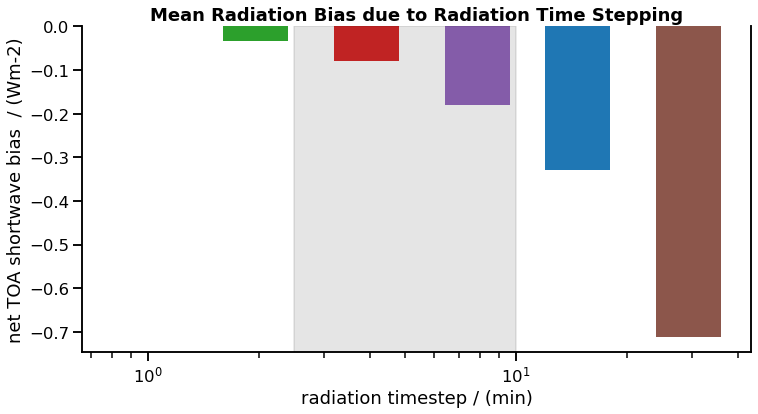

In [17]:

fig = plt.figure(figsize = (12, 6))
ax = plt.gca()

#y = dset['case1']['asob_t'].isel(time=-10).sel(expname = explist_case1).load().data

cols = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5']
marks= ['o', 'D', '*']
for k, case in enumerate(['case2']):
    for i in range( len(dt_rad)):
    
        x = dt_rad[i]
        y = dset[case]['asob_t'].isel(time=-1).mean('ncells').load().data

        if i == 0:
            y0 = y[1]
            
        ax.bar( x, y[i] -y0, color = cols[i] , width = 0.4*x,)


plt.xlabel('radiation timestep / (min)')
plt.ylabel('net TOA shortwave bias  / (Wm-2)')
plt.xscale('log')
plt.axvspan( 2.5,10, alpha = 0.1, color = 'k')

plt.title( 'Mean Radiation Bias due to Radiation Time Stepping', fontweight = 'bold',)
sns.despine(top = True, right = False)

## Conclusions

- **decorrelation**
    - behavior strongly depends on case
    - for scenaries with small and fast moving clouds, correlation drop already at 2 minutes radiation call frequency!
    - there is an unwanted periodic behavior between the mismatch between cloud and radiation that could imprint on dynamics
    
- **biases**
    - increase with decreasing radiation call frequency
    - could be <-0.3 W m-2 for `dt_rad = 15` minutes 